In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

matplotlib.rcParams['figure.dpi'] = 300

from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
df = pd.read_csv('/content/NIFTY 100-09-11-2015-to-14-08-2024.csv', index_col='Date', parse_dates=True, date_format='%d-%b-%y')
df.head()

,Open,High,Low,Close,Volume,Turnover (? Cr)
Date,,,,,,
2015-11-09,7903.80,8068.40,7890.85,8044.45,294972687.0,11924.26
2015-11-10,8009.10,8017.40,7896.70,7907.65,275281891.0,9744.58
2015-11-11,7964.95,7973.45,7952.05,7956.40,31847545.0,1381.73
2015-11-13,7895.35,7900.35,7853.55,7886.90,264081261.0,11076.44
2015-11-16,7859.60,7948.05,7835.65,7917.45,226332965.0,9338.65


In [3]:
df = df.dropna()

print(df.isnull().sum())
print(len(df))

Open               0
High               0
Low                0
Close              0
Volume             0
Turnover (? Cr)    0
dtype: int64
2169


In [4]:
print('Dataframe Shape: ', df.shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (2169, 6)
Null Value Present:  False


In [5]:
#Set Target Variable
output_var = pd.DataFrame(df['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [6]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2015-11-09,0.041430,0.049934,0.050708,0.064700
2015-11-10,0.046977,0.047253,0.051015,0.059877
2015-11-11,0.044651,0.044943,0.053919,0.000257
2015-11-13,0.040985,0.041101,0.048751,0.057134
2015-11-16,0.039102,0.043608,0.047811,0.047889


In [7]:
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        Y_train, Y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [8]:
# Number of rows to use for testing
n_test = 30

# Splitting the data
X_train, X_test = feature_transform[:-n_test], feature_transform[-n_test:]
Y_train, Y_test = output_var[:-n_test].values.ravel(), output_var[-n_test:].values.ravel()

In [9]:
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


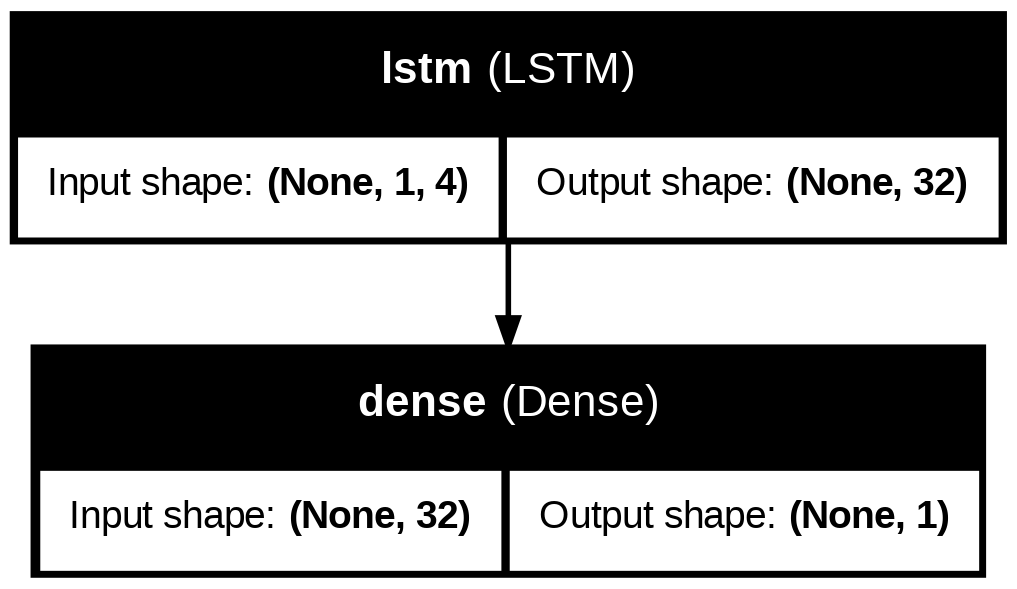

In [10]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [11]:
history = lstm.fit(X_train, Y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 113646928.0000
Epoch 2/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 113524960.0000
Epoch 3/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 113262152.0000
Epoch 4/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 112843368.0000
Epoch 5/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 112286880.0000
Epoch 6/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 111612432.0000
Epoch 7/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 110835256.0000
Epoch 8/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 109966600.0000
Epoch 9/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 109015032.0000
Epoch 10/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 107987224.0000
Epoch 11/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 106888648.0000
Epoch 12/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 105723968.0000
Epoch 13/100
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 104497120.0000
Epoch 14

In [12]:
Y2_pred = lstm.predict(X_train)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [13]:
Y_pred = lstm.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


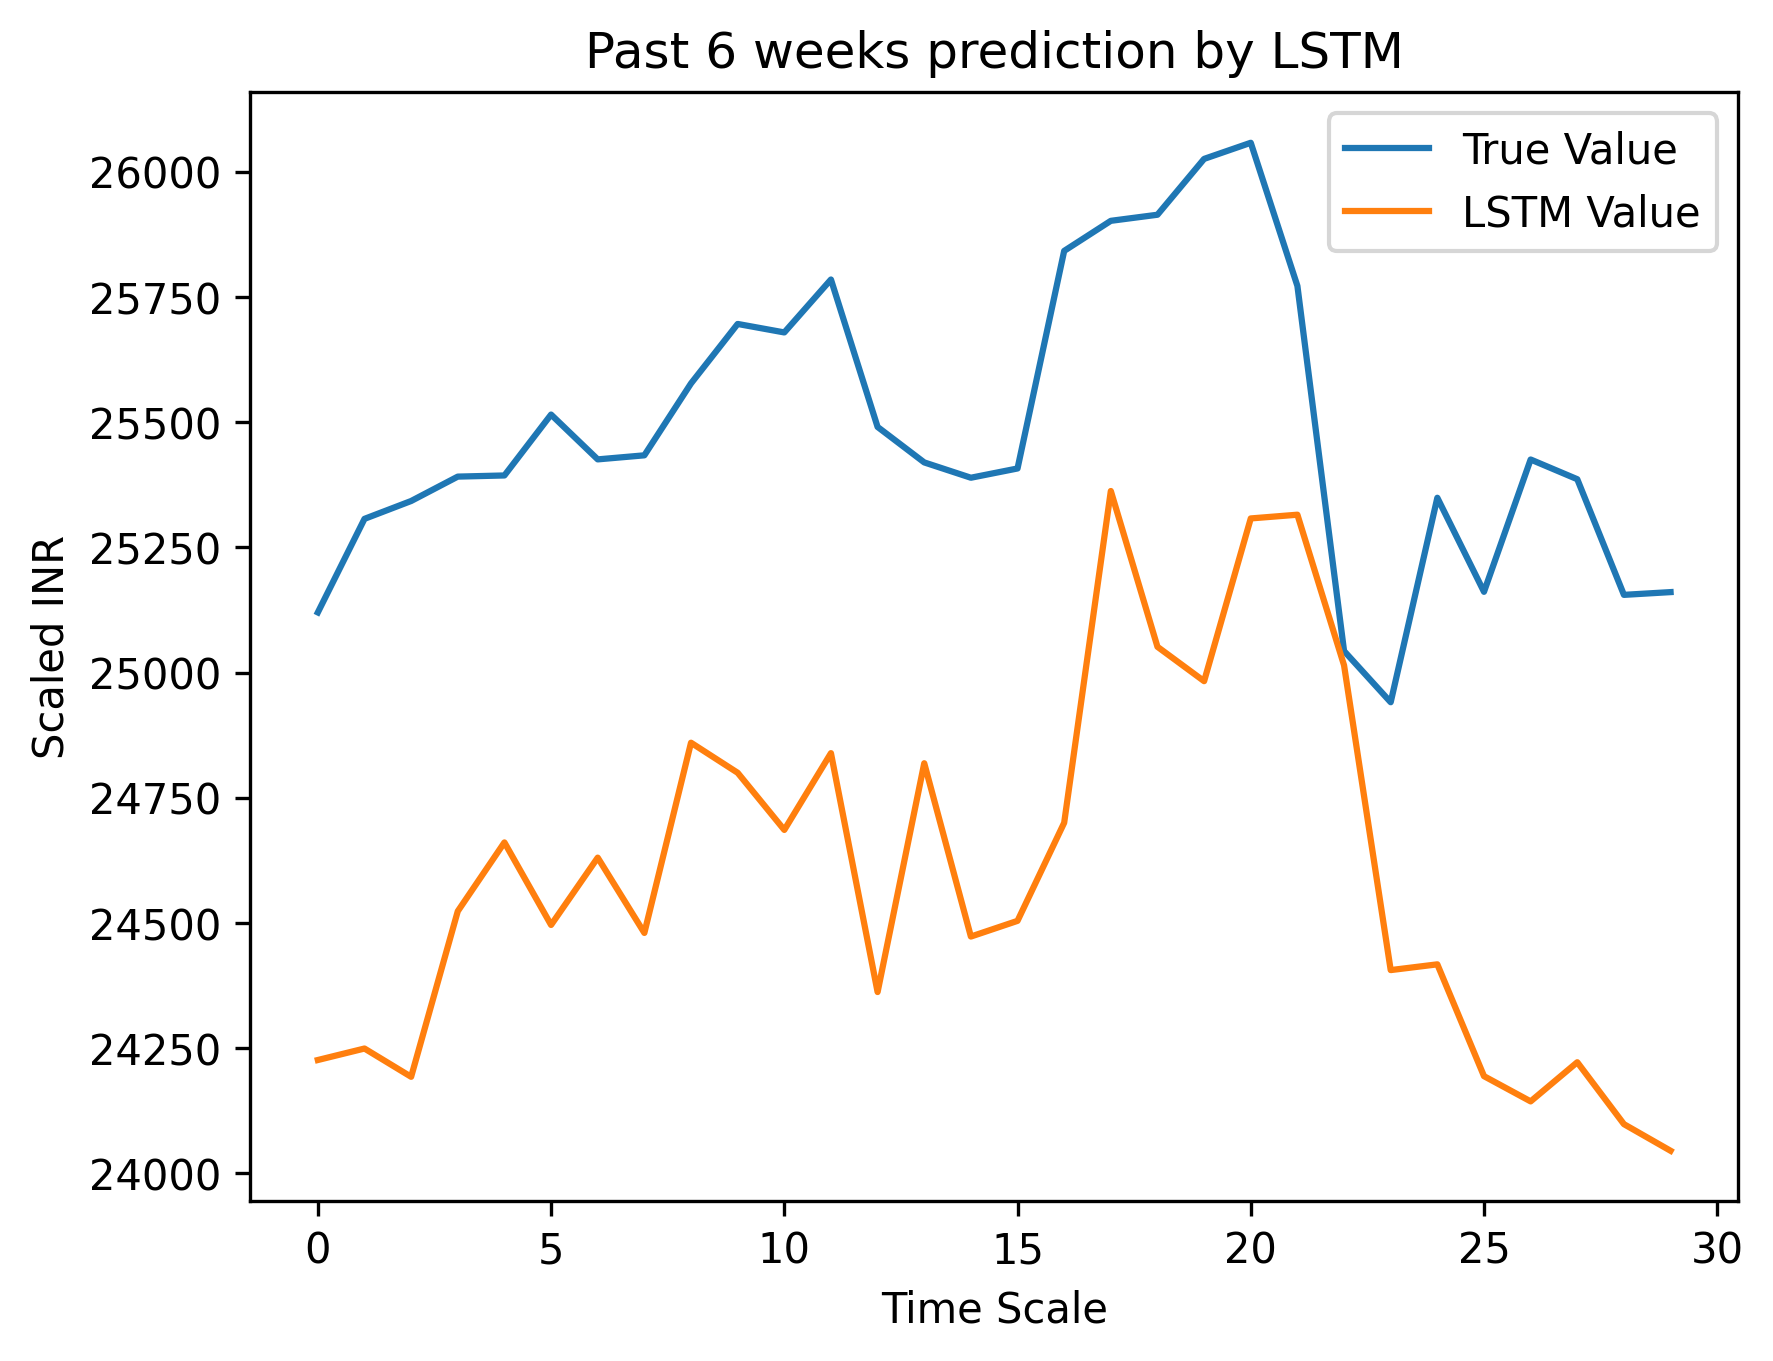

In [14]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(Y_test, label='True Value')
plt.plot(Y_pred, label='LSTM Value')
plt.title('Past 6 weeks prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled INR')
plt.legend()
plt.show()

In [15]:
lstm.save('lstm_weights.h5')

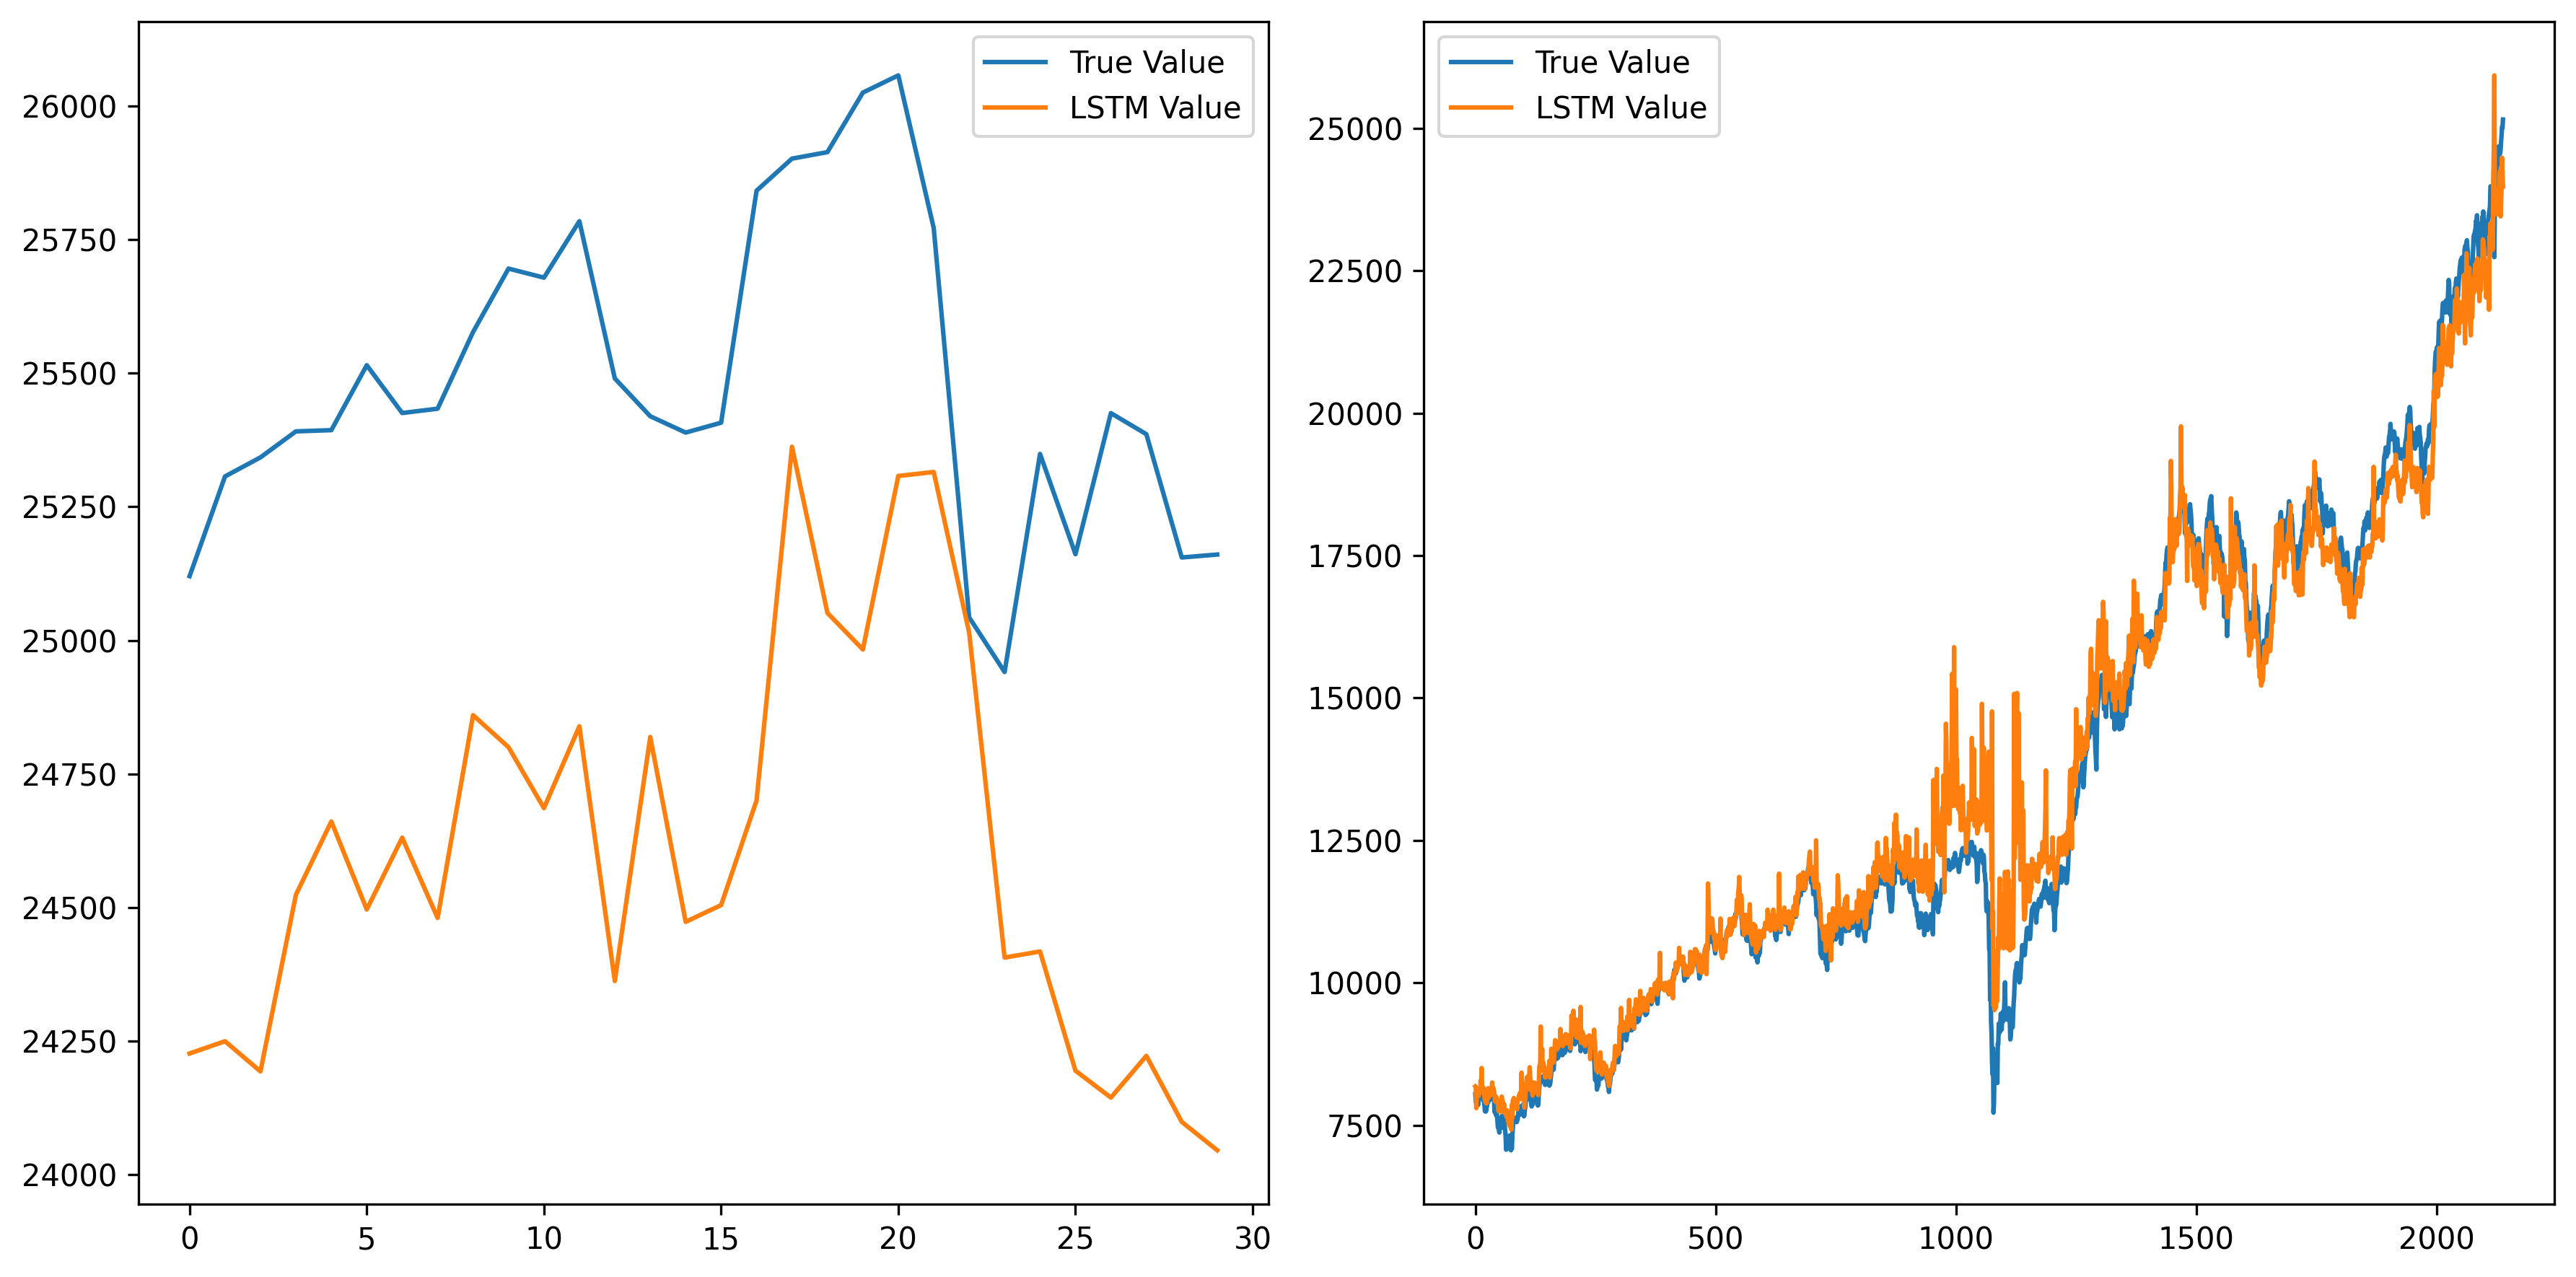

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Create scatter plot in the first subplot
ax1.plot(Y_test, label='True Value')
ax1.plot(Y_pred, label='LSTM Value')


ax1.legend()
# Create line plot in the second subplot
ax2.plot(Y_train, label='True Value')
ax2.plot(Y2_pred, label='LSTM Value')


ax2.legend()
# Adjust layout to prevent overlap
plt.tight_layout()
# Show the plot
plt.show()

In [17]:
ytrp = (np.array(Y2_pred)).reshape(2139)
ytep = (np.array(Y_pred)).reshape(30)
ytr = np.array(Y_train)
yte = np.array(Y_test)

In [18]:
etr = ((ytrp-ytr)*(ytrp-ytr)/(ytr*ytr)).mean()
ete = ((ytep-yte)*(ytep-yte)/(yte*yte)).mean()
print("Training MSE =", etr*100)
print("Testing MSE =", ete*100)

Training MSE = 0.39583398860257457
Testing MSE = 0.12960263161783275
